# **Coronavirus Tweet Sentiment Analysis**

# Problem Staemnet
This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then. The names and usernames have been given codes to avoid any privacy concerns

Location
TweetAt
Original Tweet
Sentiment
User Name
Screen Name

    fields:- username, screenname, location, tweetat, originaltweet, sentiment-target variable

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud
import nltk
nltk.download('all',quiet=True)
from PIL import Image

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
database = "coronavirus-tweets.csv"
tweet =pd.read_csv(database)

In [5]:
tweet

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂ’s getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [6]:
tweet.shape

(41157, 6)

In [7]:
tweet.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [8]:
tweet.index

RangeIndex(start=0, stop=41157, step=1)

In [9]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [10]:
tweet.duplicated().sum()

0

In [11]:
tweet.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [12]:
tweet.isnull().sum().sort_values(ascending=False)


Location         8590
UserName            0
ScreenName          0
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [13]:
tweet.columns


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [14]:
tweet.describe(include='all')

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
count,41157.000000,41157.000000,32567,41157,41157,41157
unique,NaN,NaN,12220,30,41157,5
top,NaN,NaN,London,20-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Positive
freq,NaN,NaN,540,3448,1,11422
mean,24377.000000,69329.000000,NaN,NaN,NaN,NaN
std,11881.146851,11881.146851,NaN,NaN,NaN,NaN
min,3799.000000,48751.000000,NaN,NaN,NaN,NaN
25%,14088.000000,59040.000000,NaN,NaN,NaN,NaN
50%,24377.000000,69329.000000,NaN,NaN,NaN,NaN
75%,34666.000000,79618.000000,NaN,NaN,NaN,NaN


In [15]:
print(tweet.apply(lambda col: col.unique())) 

UserName         [3799, 3800, 3801, 3802, 3803, 3804, 3805, 380...
ScreenName       [48751, 48752, 48753, 48754, 48755, 48756, 487...
Location         [London, UK, Vagabonds, nan, ÃœT: 36.319708,-8...
TweetAt          [16-03-2020, 17-03-2020, 18-03-2020, 19-03-202...
OriginalTweet    [@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/...
Sentiment        [Neutral, Positive, Extremely Negative, Negati...
dtype: object


In [16]:
tweet.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [17]:
tweet.Location.unique()

array(['London', 'UK', 'Vagabonds', ..., 'Juba south sudan', 'OHIO',
       'i love you so much || he/him'], dtype=object)

In [18]:
sentiment_count = tweet['Sentiment'].value_counts().reset_index()
sentiment_count.columns = ['Sentiment','count']
sentiment_count

,Sentiment,count
0,Positive,11422
1,Negative,9917
2,Neutral,7713
3,Extremely Positive,6624
4,Extremely Negative,5481


Text(0, 0.5, 'count')

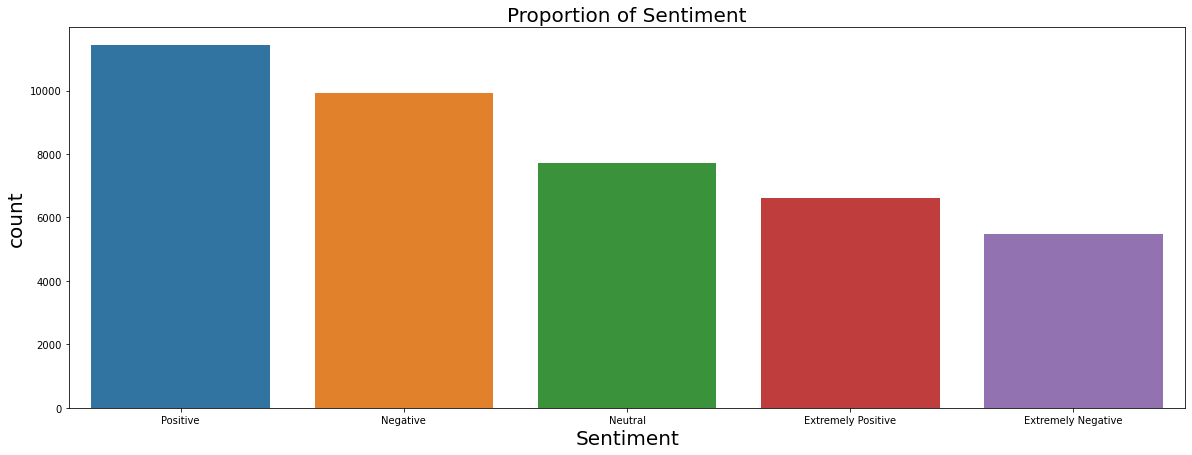

In [19]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x="Sentiment", y='count', data=sentiment_count)
ax.set_title("Proportion of Sentiment", fontsize=20)
ax.set_xlabel("Sentiment", fontsize=20)
ax.set_ylabel('count', fontsize=20)

In [20]:
# replacing values
replace_values = {"Sentiment":{'Extremely Negative':'Negative', 'Extremely Positive':'Positive'}}
tweet = tweet.replace(replace_values)

In [21]:
sentiment_count1 = tweet['Sentiment'].value_counts().reset_index()
sentiment_count1.columns = ['Sentiment','count']
sentiment_count1

,Sentiment,count
0,Positive,18046
1,Negative,15398
2,Neutral,7713


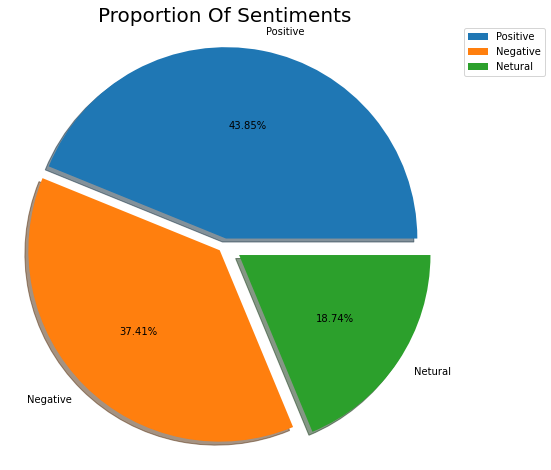

In [22]:
sentiment_count1 = tweet['Sentiment'].value_counts().to_list()
labels=['Positive','Negative','Netural']
plt.figure(figsize=(10,8))
plt.pie(x=sentiment_count1,explode=[0.04,0.04,0.1],shadow= True,labels=labels,autopct="%.2f%%",radius=1.1)
plt.title("Proportion Of Sentiments", fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [23]:
Top_Location_Of_tweet= tweet['Location'].value_counts().head(10)
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

In [24]:
Top_Location_Of_tweet

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [25]:
Top_Location_Of_tweet=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet.reset_index(inplace=True)
Top_Location_Of_tweet.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet

,Location,Location_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


[Text(0, 0, 'London'),
 Text(1, 0, 'United States'),
 Text(2, 0, 'London, England'),
 Text(3, 0, 'New York, NY'),
 Text(4, 0, 'Washington, DC'),
 Text(5, 0, 'United Kingdom'),
 Text(6, 0, 'Los Angeles, CA'),
 Text(7, 0, 'India'),
 Text(8, 0, 'UK'),
 Text(9, 0, 'Australia')]

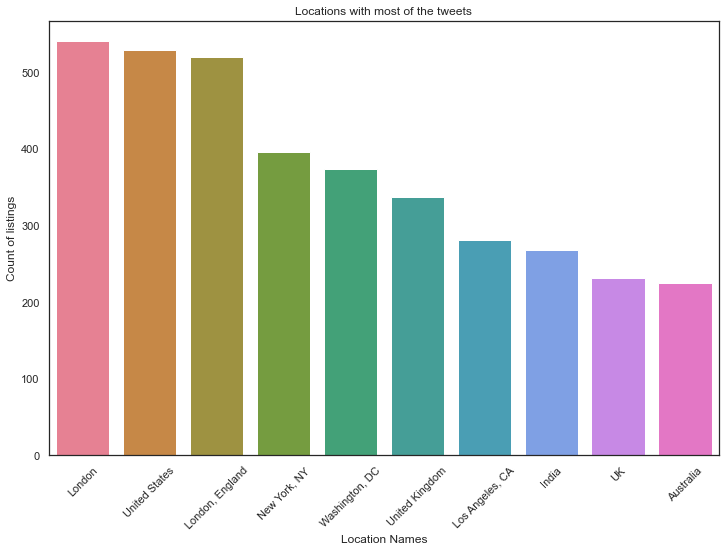

In [26]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet,palette="husl")
viz_1.set_title('Locations with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Location Names')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

In [27]:
tweet['text_length'] = tweet['OriginalTweet'].apply(len)

In [28]:
tweet_character_length=tweet['text_length'].sort_values(ascending=False)

In [29]:
top_tweet_character_length=pd.DataFrame(tweet_character_length)
top_tweet_character_length.reset_index(inplace=True)
top_tweet_character_length.rename(columns={'index':'Original_Tweet_Row', 'text_length':'tweet_character_Count'}, inplace=True)

In [30]:
top_tweet_character_length

,Original_Tweet_Row,tweet_character_Count
0,25160,355
1,7483,350
2,29688,341
3,17811,340
4,27346,338
...,...,...
41152,15577,12
41153,16872,11
41154,35526,11
41155,20467,11


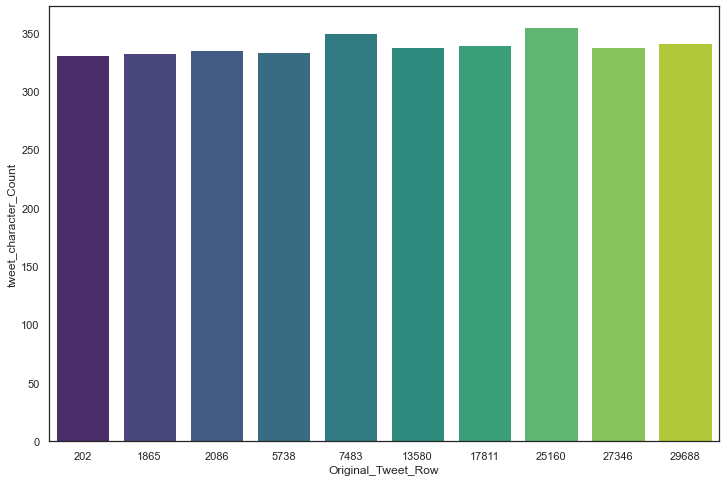

In [31]:
top_tweet_length=top_tweet_character_length.head(10).sort_values(by='tweet_character_Count',ascending=False)
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x="Original_Tweet_Row", y="tweet_character_Count", data=top_tweet_length, palette='viridis')

In [32]:
tweet['TweetAt'].value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

In [33]:
tweet['TweetAt'].value_counts().head(15)

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
Name: TweetAt, dtype: int64

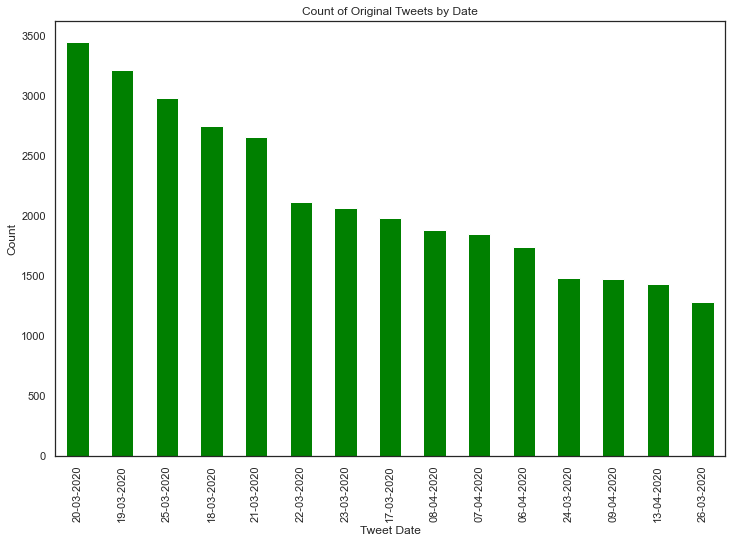

In [34]:
import pandas as pd
import plotly.express as px
tweet['TweetAt'].value_counts().head(15).plot(kind='bar',color='green')

plt.title('Count of Original Tweets by Date')
plt.xlabel('Tweet Date')
plt.ylabel('Count')

plt.show()

In [35]:
tweet.isnull().sum().sort_values(ascending=False)

Location         8590
UserName            0
ScreenName          0
TweetAt             0
OriginalTweet       0
Sentiment           0
text_length         0
dtype: int64

In [36]:
print(tweet[['OriginalTweet', 'Sentiment']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB
None


In [37]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [38]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


In [39]:
import regex as re

In [40]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

def transform_text(text):
    text = text.lower()
    
    text = re.sub(r'http\S+', '', text)
    
    words = nltk.word_tokenize(text)
    
    words = [word for word in words if word.isalnum()]
    
    stopwords_set = set(stopwords.words('english'))
    punctuation_set = set(string.punctuation)
    words = [word for word in words if word not in stopwords_set and word not in punctuation_set]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(lemmatized_words)

In [41]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today https/20.89.")

'gon na home soon want talk stuff anymore tonight k cried enough today'

In [43]:
tweet["Clean_Tweets"] = tweet['OriginalTweet'].apply(transform_text)

In [44]:
 tweet.iloc[25160]["OriginalTweet"]

'Crude oil dropped to its lowest in 17 years in Asia as #coronavirus in #US and #EU shows little sign of slowing.\r\r\n\r\r\nNoon prices:\r\r\n#SPX500Â–2504.3\r\r\n#NAS100Â–7507.1\r\r\n#WTIÂ–20.24\r\r\n#GOLDÂ–1618.08\r\r\n#SILVERÂ–14.118\r\r\n\r\r\nWatch these prices closely: https://t.co/WuiEEfSNOj\r\r\n\r\r\n#COVID19 #CoronaVirusOutbreak https://t.co/j68MZIDXAd https://t.co/9MyqGxutUU'

In [45]:
tweet.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text_length,Clean_Tweets
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,menyrbie chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,237,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,131,coronavirus australia woolworth give elderly d...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,306,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,310,ready go supermarket covid19 outbreak paranoid...


In [46]:
tweet['temp_list'] = tweet['Clean_Tweets'].apply(lambda x:str(x).split())

In [47]:
tweet['temp_list']

0                                     [menyrbie, chrisitv]
1        [advice, talk, neighbour, family, exchange, ph...
2        [coronavirus, australia, woolworth, give, elde...
3        [food, stock, one, empty, please, panic, enoug...
4        [ready, go, supermarket, covid19, outbreak, pa...
                               ...                        
41152    [airline, pilot, offering, stock, supermarket,...
41153    [response, complaint, provided, citing, relate...
41154    [know, itâ, getting, tough, kameronwilds, rati...
41155    [wrong, smell, hand, sanitizer, starting, turn...
41156    [tartiicat, well, rift, going, amazon, rn, alt...
Name: temp_list, Length: 41157, dtype: object

In [48]:
from collections import Counter
import pandas as pd

word_list = [word for sublist in tweet['temp_list'] for word in sublist]

word_counts = Counter(word_list)

top_words = pd.DataFrame(word_counts.most_common(30), columns=['Common_words', 'count'])

styled_top_words = top_words.style.background_gradient(cmap='Reds')

In [49]:
top_words

,Common_words,count
0,coronavirus,18043
1,price,8937
2,store,8162
3,supermarket,7734
4,food,7223
5,grocery,6743
6,people,5572
7,amp,5197
8,consumer,5134
9,covid19,4935


In [50]:
neutral=pd.DataFrame(tweet[['Clean_Tweets']] [tweet['Sentiment'] == 'Neutral'])
positive=pd.DataFrame(tweet[['Clean_Tweets']] [tweet['Sentiment'] == 'Positive'])
negative=pd.DataFrame(tweet[['Clean_Tweets']] [tweet['Sentiment'] == 'Negative'])

In [51]:
positive

,Clean_Tweets
1,advice talk neighbour family exchange phone nu...
2,coronavirus australia woolworth give elderly d...
3,food stock one empty please panic enough food ...
5,news regionâ first confirmed case came sulliva...
6,cashier grocery store sharing insight prove cr...
...,...
41146,gold price rose high today due coronavirus inc...
41148,uv light sterilizer sanitizer mask mobile phon...
41150,never weâ situation amp world going supermarke...
41151,mrsilverscott definitely man feel like fall ne...


In [52]:
negative

,Clean_Tweets
4,ready go supermarket covid19 outbreak paranoid...
9,corona prevention stop buy thing cash use onli...
20,100 nation inficted covid 19 world must play f...
24,10downingstreet grantshapps done ensure food e...
26,preparation higher demand potential food short...
...,...
41133,singaporean politician slammed woman snapped s...
41147,yâ really shitting much home covid19 coronavir...
41149,still shocked number toronto supermarket emplo...
41153,response complaint provided citing related del...


In [53]:
neutral

,Clean_Tweets
0,menyrbie chrisitv
7,supermarket today buy toilet paper rebel toile...
10,month crowding supermarket restaurant however ...
16,13
17,eyeonthearctic 16mar20 russia consumer surveil...
...,...
41141,coronavirus narendramodi atcard stayhome lockd...
41143,5gtowers ecuadorunido cruiseships savethechild...
41144,gamzap npr supermarket nearby getting
41152,airline pilot offering stock supermarket shelf...


In [54]:
spam_corpus = []
for msg in tweet[tweet['Sentiment'] =='Neutral']['Clean_Tweets'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [55]:
top_words

,Common_words,count
0,coronavirus,18043
1,price,8937
2,store,8162
3,supermarket,7734
4,food,7223
5,grocery,6743
6,people,5572
7,amp,5197
8,consumer,5134
9,covid19,4935


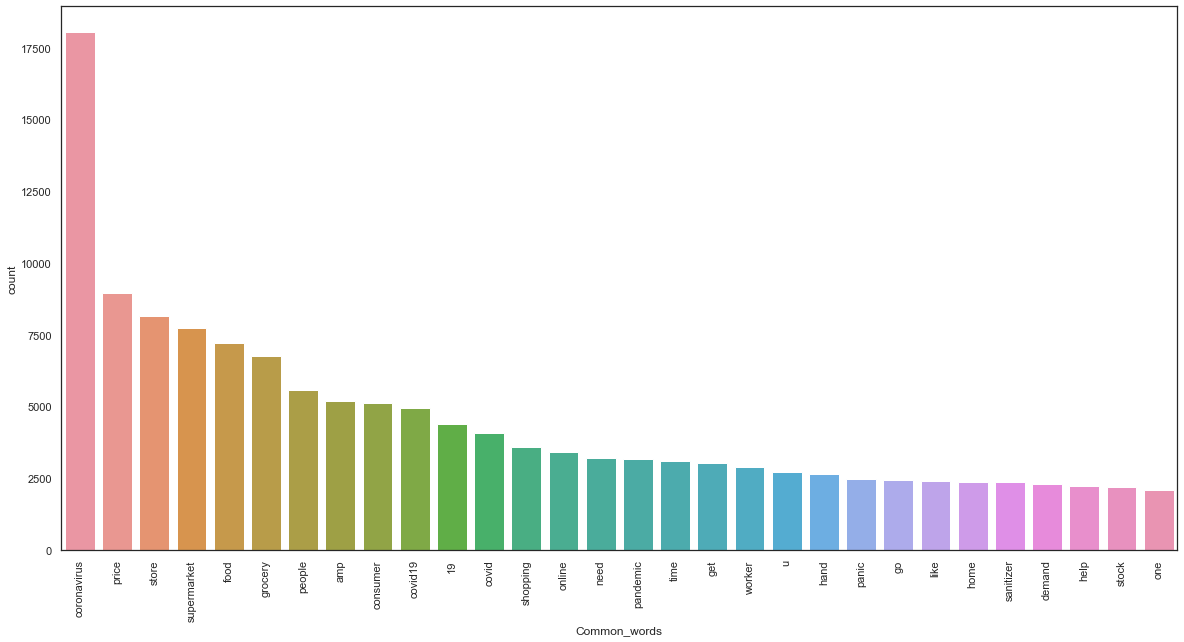

In [56]:
from collections import Counter
plt.figure(figsize=(20,10))
sns.barplot(x='Common_words',y='count',data=top_words)
plt.xticks(rotation='vertical')
plt.show()

In [57]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [58]:
tweet_wc = wc.generate(str(neutral['Clean_Tweets']))
plt.figure(figsize=(10,10))
plt.imshow(tweet_wc)

ValueError: Only supported for TrueType fonts

In [59]:
tweet_wc = wc.generate(str(positive['Clean_Tweets']))
plt.figure(figsize=(10,10))
plt.imshow(tweet_wc)

ValueError: Only supported for TrueType fonts

In [60]:
tweet_wc = wc.generate(str(negative['Clean_Tweets']))
plt.figure(figsize=(10,10))
plt.imshow(tweet_wc)

ValueError: Only supported for TrueType fonts

In [61]:
X= tweet['Clean_Tweets']
y=tweet['Sentiment']

In [62]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=10)

In [63]:
print(X_train.shape)
y_test.shape

(32925,)


(8232,)

In [64]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
 6   text_length    41157 non-null  int64 
 7   Clean_Tweets   41157 non-null  object
 8   temp_list      41157 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.8+ MB


In [65]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [66]:
bw=CountVectorizer(binary=False,max_df=1.0,min_df=5,ngram_range=(1,2))
bw_X_train=bw.fit_transform(X_train.astype(str).str.strip())

In [67]:
bw_X_train.shape

(32925, 19306)

In [68]:
bw_X_test=bw.transform(X_test.astype(str).str.strip())

In [69]:
bw_X_test.shape

(8232, 19306)

In [71]:
lr_cv = LogisticRegression()

parameters = {
    'penalty': ['l1', 'l2'],  
    'C': [100, 10, 1.0, 0.1, 0.01]  
}

logreg_Gcv = GridSearchCV(lr_cv, parameters, cv=15)

logreg_Gcv.fit(bw_X_train, y_train)

GridSearchCV(cv=15, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2']})

In [72]:
pred_lr_cv = logreg_Gcv.predict(bw_X_test)

In [73]:
pred_lr_cv 

array(['Negative', 'Positive', 'Positive', ..., 'Neutral', 'Positive',
       'Positive'], dtype=object)

In [74]:
accuracy_lr_cv = accuracy_score(y_test,pred_lr_cv)
print("Accuracy :",(accuracy_lr_cv))

Accuracy : 0.7894800777453839


In [75]:
label=['neutral','positive','negative']
print(classification_report(y_test,pred_lr_cv))

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79      3080
     Neutral       0.69      0.69      0.69      1543
    Positive       0.83      0.83      0.83      3609

    accuracy                           0.79      8232
   macro avg       0.77      0.77      0.77      8232
weighted avg       0.79      0.79      0.79      8232



[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative'), Text(0, 2.5, 'Netural')]

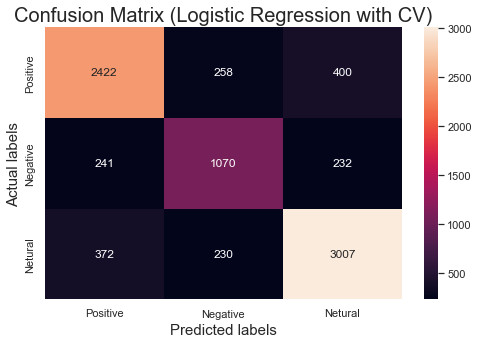

In [76]:
cf1= (confusion_matrix(y_test,pred_lr_cv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf1, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Logistic Regression with CV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [77]:
dt_cv=DecisionTreeClassifier()

dt_cv.fit(bw_X_train,y_train)

pred_dt_cv=dt_cv.predict(bw_X_test)

In [78]:
cv_score_dt_cv= cross_val_score(dt_cv,bw_X_train,y_train, cv=5)
print("Accuracy: {}" .format(np.mean(cv_score_dt_cv)))

Accuracy: 0.7014426727410782


In [79]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,pred_dt_cv))

              precision    recall  f1-score   support

    Negative       0.69      0.68      0.68      3080
     Neutral       0.64      0.67      0.66      1543
    Positive       0.75      0.74      0.74      3609

    accuracy                           0.71      8232
   macro avg       0.69      0.70      0.70      8232
weighted avg       0.71      0.71      0.71      8232



[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative'), Text(0, 2.5, 'Netural')]

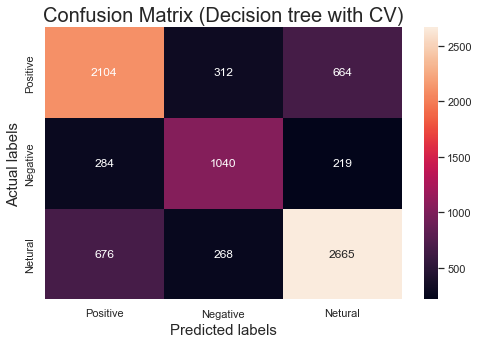

In [80]:
cf2= (confusion_matrix(y_test,pred_dt_cv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf2, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Decision tree with CV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)


In [81]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [82]:
mnb = MultinomialNB()
bnb = BernoulliNB()

In [83]:
mnb.fit(bw_X_train,y_train)
y_pred2 = mnb.predict(bw_X_test)
accuracy_mnb = accuracy_score(y_test,y_pred2)
print(accuracy_mnb)

0.6865889212827988


In [84]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

    Negative       0.69      0.72      0.70      3080
     Neutral       0.57      0.53      0.55      1543
    Positive       0.73      0.73      0.73      3609

    accuracy                           0.69      8232
   macro avg       0.66      0.66      0.66      8232
weighted avg       0.69      0.69      0.69      8232



[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative'), Text(0, 2.5, 'Netural')]

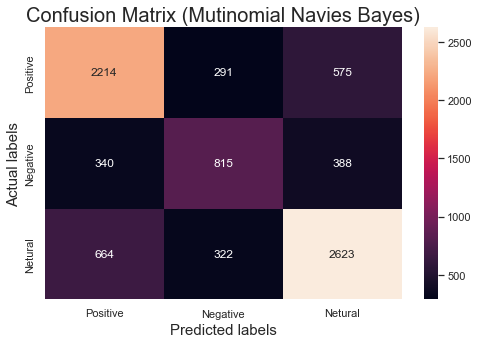

In [85]:
cf3= (confusion_matrix(y_test,y_pred2))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf3, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Mutinomial Navies Bayes)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [86]:
bnb.fit(bw_X_train,y_train)
y_pred3 = bnb.predict(bw_X_test)
accuracy_bnb = accuracy_score(y_test,y_pred3)
print(accuracy_bnb)

0.6955782312925171


In [87]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

    Negative       0.71      0.69      0.70      3080
     Neutral       0.56      0.70      0.62      1543
    Positive       0.77      0.70      0.73      3609

    accuracy                           0.70      8232
   macro avg       0.68      0.70      0.68      8232
weighted avg       0.71      0.70      0.70      8232



[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative'), Text(0, 2.5, 'Netural')]

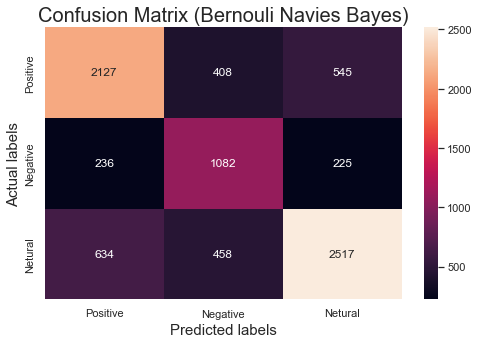

In [88]:
cf4= (confusion_matrix(y_test,y_pred3))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf4, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Bernouli Navies Bayes)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,9]}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)

grid_search.fit(bw_X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Mean cross-validation score:', grid_search.best_score_)

Best hyperparameters: {'n_neighbors': 1}
Mean cross-validation score: 0.38320425208807896


In [90]:
pred_knn_cv = grid_search.predict(bw_X_test)

In [91]:
pred_knn_cv

array(['Neutral', 'Neutral', 'Negative', ..., 'Neutral', 'Negative',
       'Negative'], dtype=object)

In [92]:
accuracy_KNN = accuracy_score(y_test,pred_knn_cv)
print("Accuracy :",(accuracy_KNN))

Accuracy : 0.39322157434402333


In [93]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,pred_knn_cv))

              precision    recall  f1-score   support

    Negative       0.66      0.30      0.41      3080
     Neutral       0.24      0.84      0.38      1543
    Positive       0.70      0.29      0.41      3609

    accuracy                           0.39      8232
   macro avg       0.53      0.47      0.40      8232
weighted avg       0.60      0.39      0.40      8232



[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative'), Text(0, 2.5, 'Netural')]

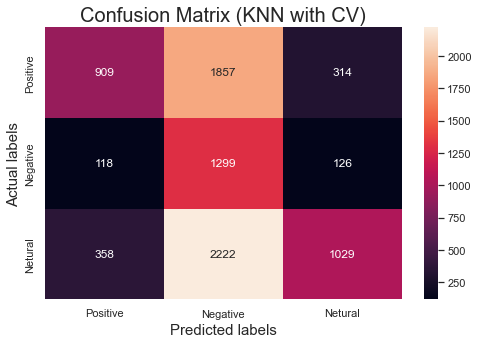

In [94]:
cf_knn= (confusion_matrix(y_test,pred_knn_cv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf_knn, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (KNN with CV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
svm_cv = SVC()

svm_cv.fit(bw_X_train,y_train)

pred_svm_cv = svm_cv.predict(bw_X_test)

In [ ]:
pred_svm_cv

In [ ]:
accuracy_svc = accuracy_score(y_test,pred_svm_cv)
print("Accuracy :",(accuracy_svc))

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,pred_svm_cv))

In [ ]:
cf6= (confusion_matrix(y_test,pred_svm_cv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf6, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (SVM with CV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
rf_clf =RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(bw_X_train, y_train)

y_pred_rf = rf_clf.predict(bw_X_test)

accuracy_rf = (y_pred_rf == y_test).mean()
print('Accuracy_rf:', accuracy_rf)

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,y_pred_rf))

In [ ]:
cf7= (confusion_matrix(y_test,y_pred_rf))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf7, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Random Forest with CV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
sgd_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, random_state=42, max_iter=1000)

sgd_clf.fit(bw_X_train, y_train)

y_pred_sgd = sgd_clf.predict(bw_X_test)

accuracy_sgd= accuracy_score(y_test, y_pred_sgd)
print('Accuracy_sgd:', accuracy_sgd)

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,y_pred_sgd))

In [ ]:
cf8= (confusion_matrix(y_test,y_pred_sgd))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf8, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (STOCHASTIC GRADIENT DESCENT CLASSIFIER with CV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
X=tweet['Clean_Tweets']
y=tweet['Sentiment']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=10)

In [ ]:
print(X_train.shape)
y_test.shape

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [ ]:
tv=TfidfVectorizer(use_idf=True,max_df=1.0,min_df=5,ngram_range=(1,2),sublinear_tf=True)
tv_X_train=tv.fit_transform(X_train.astype(str).str.strip())

In [ ]:
tv_X_train.shape

In [ ]:
tv_X_test=tv.transform(X_test.astype(str).str.strip())

In [ ]:
lr_tv=LogisticRegression()
parameters = dict(penalty=['l1', 'l2'],C=[100, 10, 1.0, 0.1, 0.01])

lr_tv_Gcv=GridSearchCV(lr_tv,parameters,cv=5)

lr_tv_Gcv.fit(tv_X_train,y_train)

In [ ]:
pred_lr_tv_Gcv = lr_tv_Gcv.predict(tv_X_test)

In [ ]:
accuracy_lr_Gcv = accuracy_score(y_test,pred_lr_tv_Gcv)
print("Accuracy :",(accuracy_lr_Gcv))

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,pred_lr_tv_Gcv))

In [ ]:
cf1a= (confusion_matrix(y_test,pred_lr_tv_Gcv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf1a, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Logistic Regg with TF/IDF)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
dt_tv=DecisionTreeClassifier()

dt_tv.fit(tv_X_train,y_train)

pred_dt_tv=dt_tv.predict(tv_X_test)

In [ ]:
pred_dt_tv

In [ ]:
cv_score_dt_tv= cross_val_score(dt_tv,tv_X_train,y_train, cv=5)
print("Accuracy: {}" .format(np.mean(cv_score_dt_tv)))

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,pred_dt_tv))

In [ ]:
cf2a= (confusion_matrix(y_test,pred_dt_tv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf2a, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Decision Tree with TF/IDF)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [ ]:
mnb = MultinomialNB()
bnb = BernoulliNB()

In [ ]:
mnb.fit(tv_X_train,y_train)
y_pred2_mnb_tv = mnb.predict(tv_X_test)
accuracy_mnb_tv = accuracy_score(y_test,y_pred3)
print(accuracy_score(y_test,y_pred2_mnb_tv))

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,y_pred2_mnb_tv))

In [ ]:
cf3a= (confusion_matrix(y_test,y_pred2_mnb_tv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf3a, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Multinominal with TF/IDF)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
bnb.fit(tv_X_train,y_train)
y_pred3_bnb_tv = bnb.predict(tv_X_test)
accuracy_bnb_tv = accuracy_score(y_test,y_pred3)
print(accuracy_score(y_test,y_pred3_bnb_tv))

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,y_pred3_bnb_tv))

In [ ]:
cf4a= (confusion_matrix(y_test,y_pred3_bnb_tv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf4a, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Bernouli with TF/IDF)', fontsize=20)
ax.xaxis.set_ticklabels(labels)

In [ ]:
knn = KNeighborsClassifier()
param = {'n_neighbors': [1,2,3,4,5,6,7,8]}
knn_tv = GridSearchCV(estimator=knn,param_grid=param)

knn_tv.fit(tv_X_train, y_train)

In [ ]:
pred_knn_tv = knn_tv.predict(tv_X_test)

In [ ]:
pred_knn_tv

In [ ]:
accuracy_KNN_tv = accuracy_score(y_test,pred_knn_tv)
print("Accuracy :",(accuracy_KNN_tv))

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,pred_knn_tv))

In [ ]:
cf4a= (confusion_matrix(y_test,pred_knn_tv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf4a, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (KNN TF/IDF with GridsearchCV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
rf_clf =RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(tv_X_train, y_train)

y_pred_rf_tv = rf_clf.predict(tv_X_test)

accuracy_tv_rf = (y_pred_rf_tv == y_test).mean()
print('Accuracy_tv_rf:', accuracy_tv_rf)

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,y_pred_rf_tv))

In [ ]:
cf5a= (confusion_matrix(y_test,y_pred_rf_tv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf5a, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Random Forest with GridsearchCV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
sgd_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, random_state=42, max_iter=1000)

sgd_clf.fit(tv_X_train, y_train)

y_pred_sgd_tv = sgd_clf.predict(tv_X_test)

accuracy_sgd_tv= accuracy_score(y_test, y_pred_sgd_tv)
print('Accuracy:', accuracy_sgd_tv)

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,y_pred_sgd_tv ))

In [ ]:
cf6a= (confusion_matrix(y_test,y_pred_sgd_tv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf6a, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Stochastics Classifer with GridsearchCV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
svm_cv = SVC()

svm_cv.fit(tv_X_train,y_train)

pred_svm_cv = svm_cv.predict(tv_X_test)

In [ ]:
accuracy_svc = accuracy_score(y_test,pred_svm_cv)
print("Accuracy :",(accuracy_svc))

In [ ]:
label=['Neutral','Positive','Negative']
print(classification_report(y_test,pred_svm_cv))

In [ ]:
cf7a= (confusion_matrix(y_test,pred_svm_cv))
plt.figure(figsize=(8,5))
ax= plt.subplot()
sns.heatmap(cf7a, annot=True, fmt=".0f",ax = ax)

ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('Actual labels', fontsize=15)
ax.set_title('Confusion Matrix (Support Vector Machine with GridsearchCV)', fontsize=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
acurracy = {'Model':  ['Logistic Regression with GridserachCV', 'Decision Tree Classifier','K-Nearest-Neighbours Classifier','Support-Vector-Machine Classifier','Multinomial Navies Bayes','Bernoulli Navies Bayes','Stochastic Gradient Descent','Random Forest'],
        'Count Vector':  [accuracy_lr_cv,np.mean(cv_score_dt_cv),accuracy_KNN,accuracy_svc,accuracy_bnb,accuracy_mnb,accuracy_sgd,accuracy_rf],
        'Tf/idf Vector': [accuracy_lr_Gcv,np.mean(cv_score_dt_tv),accuracy_KNN_tv,accuracy_svc,accuracy_mnb_tv,accuracy_bnb_tv,accuracy_sgd_tv,accuracy_tv_rf]}

cv_score_table= pd.DataFrame (acurracy, columns = ['Model','Count Vector','Tf/idf Vector'])
cv_score_table